In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize 
import gensim
import gensim.downloader as api
import string
import re
import numpy as np
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.corpus import stopwords 
from fuzzywuzzy import fuzz
from sklearn import preprocessing
from numpy import dot
from numpy.linalg import norm
from gensim.models import Word2Vec, KeyedVectors
from scipy.cluster import  hierarchy

## Load pretrained Word2Vec and sample data

In [ ]:
#model = api.load("word2vec-google-news-300")

In [5]:
model_path = api.load("word2vec-google-news-300", return_path=True)

In [6]:
w2v = KeyedVectors.load_word2vec_format(model_path, binary= True)

In [91]:
# normalized model so we can use wmdistance later
w2v_norm = KeyedVectors.load_word2vec_format(model_path, binary= True)
w2v_norm.init_sims(replace=True)

In [9]:
with open('../data/data.txt', 'r') as f: 
    data = f.readlines()
f.close()
data = [x.rstrip().lstrip().strip('\",') for x in data]
print (data)

['Marks and Spencers Ltd', 'M&S Limited', 'NVIDIA Ireland', 'SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', '44 CHINA ROAD, KOWLOON, HONG KONG', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'LONDON', 'HONG KONG', 'ASIA', 'JP Morgan & Chase Co.', 'ICNAO02312', 'TOYS', '5 Time Square, New York, NY 10036', 'COMPUTER PARTS', 'INTEL CORPORATION', 'INTEL CO', 'Ryland Group Inc.', 'Sabre Holdings Corp', 'Safeco Corp', '4CE0460D0G', 'Vero Beach, Florida', 'WINE', 'Microwave', 'Plastic container', 'Europe', 'Canada', 'HGU6UH3']


## Preprocess data

In [10]:
df = pd.DataFrame()
df['text'] = data

In [139]:
table = str.maketrans('', '', string.punctuation.replace('#', '').replace('&', ''))
stop_words = set(stopwords.words('english')) 
    # After trying different preprocessing combinations, I decided not to filter out stops words, 
    # and keept '#' and '&' since they can help defining a string in our specific case 
def get_tokens(x): 
    #print (x)
    x = re.sub(r'\d', '#', x).lower()
    tokens = word_tokenize(x)
    tokens = [w.translate(table) for w in tokens]
    tokens = [x for x in tokens if x != '']
    return tokens

In [12]:
df['clean_token'] = df['text'].apply(lambda x: get_tokens(x))
df['clean_string'] = df['clean_token'].apply(lambda x: ' '.join(x))

In [282]:
bi_gram_list = [x for x in w2v.index2word if re.search('(_){1,}', x)]
bi_gram_list_lower = [x.lower() for x in bi_gram_list]

In [310]:
def get_bi_gram(x): 
    return_list = []
    last_flag = False
    for i in range(len(x)-1): 
        current_token = x[i]
        current_bigram = x[i]+'_'+x[i+1]
        if current_token != '#' and current_bigram in bi_gram_list_lower:
            matched_idx = bi_gram_list_lower.index(current_bigram)
            current_token = bi_gram_list[matched_idx]
            if i+1 == len(x)-1: 
                last_flag = True
        return_list.append(current_token)
    if last_flag == False: 
        return_list.append(x[-1])
    return return_list

In [311]:
df['clean_token_bi_gram'] = df['clean_token'].apply(lambda x: get_bi_gram(x))

## Get word2vec vectors from pretrained model

In [13]:
model_vocab = w2v.vocab

In [313]:
# get vector per string
def get_vector(x):
    agg_vector = []
    for token in x: 
        if token in model_vocab: 
            v = w2v[token]  
        elif token.capitalize() in model_vocab:
            v = w2v[token.capitalize()] 
        else: 
            #print (token, 'NOT FOUND!')
            v = w2v['#'] # assign unknown words (usually random letters in a serial number) to # to skew the vector
        agg_vector.append(v)
    agg_vector = np.array(agg_vector)
    agg_vector = np.mean(agg_vector, axis = 0)
    return agg_vector

In [314]:
df['vecter_300'] = df['clean_token_bi_gram'].apply(lambda x: get_vector(x))

## Add more features

In [315]:
# Adding word and character count, and a flag for possible company name
company_str = ['corporation', 'inc', 'co', 'corp', 'cooperatives', 'ltd', 'limited', 'company', \
               'lp', 'incorporated', 'international', 'association']
def get_word_cnt(x): 
    return len(x)

def get_char_cnt(x): 
    return len(''.join(x))

def get_company_flag(x): 
    if any(w in company_str for w in x): 
        return 1
    else: return 0 
    
def get_digits_ratio(x): 
    x = x.replace(' ', '')
    digit_count = 0
    for c in x: 
        if c.isdigit(): 
            digit_count += 1
    return digit_count/len(x)

count = lambda l1,l2: sum([1 for x in l1 if x in l2])
def get_punc_ratio(x): 
    x = x.replace(' ', '')
    punc = count(x,set(string.punctuation)) 
    return punc/len(x)
        
df['word_count'] = df['clean_token'].apply(lambda x: get_word_cnt(x))
df['char_count'] = df['clean_token'].apply(lambda x: get_char_cnt(x))
df['company_str'] = df['clean_token'].apply(lambda x: get_company_flag(x))
df['digital_ratio'] = df['text'].apply(lambda x: get_digits_ratio(x))
df['punctuation_ratio'] = df['text'].apply(lambda x: get_punc_ratio(x))

In [341]:
def concat_features(row): 
    concat_list = np.array([row['word_count'], row['char_count'], row['company_str'], row['digital_ratio'], row['punctuation_ratio']])
    new_concat_list = np.append(row['vecter_300'], concat_list)
    return new_concat_list

In [342]:
df['new_feature_concat'] = df.apply(lambda row: concat_features(row), axis = 1)

## Normalize matrix

In [343]:
def scale_mat(vec_matrix,preprocess_type):
    if preprocess_type == 'MinMax':
        scale = preprocessing.MinMaxScaler().fit(vec_matrix)  
    if preprocess_type == 'Standard':
        scale = preprocessing.StandardScaler().fit(vec_matrix)
    vals = scale.transform(vec_matrix)
    return vals

vector_matrix = np.array(df['new_feature_concat'].tolist())
vector_matrix = scale_mat(vector_matrix, 'MinMax')
print ('vector size: ', vector_matrix.shape)

vector size:  (31, 305)


In [344]:
# PCA reduce dimensions
sklearn_pca = PCA(n_components = 2)
vals_pca = sklearn_pca.fit_transform(vector_matrix)

In [345]:
# Add 2D array to df 
df['2D'] = vals_pca.tolist()

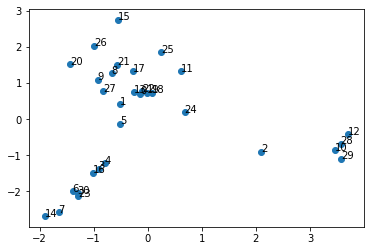

In [346]:
# plot
data2D = np.array(df['2D'].tolist())
n = df.index
plt.scatter(vals_pca[:,0], vals_pca[:,1])
for i, txt in enumerate(n):
    plt.annotate(txt, (vals_pca[i,0], vals_pca[i,1]))
plt.show()

We can see that there are some sort of patterns forming. Some examples are: 
<br> On far right there are locations: 10(LONDON), 12(ASIA), 28(Europ), and 29(Canada) 
<br> The center cluster is mostly companies: 0(Marks and Spencers Ltd), 1(M&S Limited), 21(Sabre Holdings Corp), 13(JP Morgan & Chase Co)
<br> The top part is mostly items, there are 8(HARDWOOD TABLE), 9(PLASTIC BOTTLE), 15(TOYS), 17(COMPUTER PARTS), 25(WINE), 26(microwave), 27(Plastic container)
<br> On bottom left there are serial numbers: 6(XYZ 13423 / ILD), 7(ABC/ICL/20891NC), 14(ICNAO02312), 23(4CE0460D0G), 30(HGU6UH3)

In [340]:
df

,text,clean_token,clean_string,vecter_300,word_count,char_count,company_str,new_feature_concat,digital_ratio,punctuation_ratio,2D,hierarchy_label,clean_token_bi_gram
0,Marks and Spencers Ltd,"[marks, and, spencers, ltd]",marks and spencers ltd,"[-0.081870556, -0.028320312, -0.05102539, 0.10...",4,19,1,"[-0.08187055587768555, -0.0283203125, -0.05102...",0.000000,0.000000,"[-0.21785738628969087, -0.6526475067830879]",cluster_5,"[marks, and, spencers, ltd]"
1,M&S Limited,"[m, &, s, limited]",m & s limited,"[-0.15039062, 0.09075928, -0.11743164, 0.13623...",4,10,1,"[-0.150390625, 0.09075927734375, -0.1174316406...",0.000000,0.100000,"[-0.5241411593227774, -0.3759396544394854]",cluster_5,"[m, &, s, limited]"
2,NVIDIA Ireland,"[nvidia, ireland]",nvidia ireland,"[0.01928711, -0.19091797, -0.053955078, 0.3242...",2,13,0,"[0.019287109375, -0.19091796875, -0.0539550781...",0.000000,0.000000,"[2.14325646307336, 0.7570817600426596]",cluster_2,"[nvidia, ireland]"
3,SLOUGH SE12 2XY,"[slough, se, #, #, #, xy]",slough se # # # xy,"[-0.08087158, -0.079182945, 0.05058797, 0.0112...",6,13,0,"[-0.08087158203125, -0.0791829451918602, 0.050...",0.230769,0.000000,"[-0.7947209999704078, 1.450827102862683]",cluster_3,"[slough, se, #, #, #, xy]"
4,"33 TIMBER YARD,LONDON, L1 8XY","[#, #, timber, yard, london, l, #, #, xy]",# # timber yard london l # # xy,"[-0.053792316, -0.05820041, -0.040527344, 0.02...",9,23,0,"[-0.0537923164665699, -0.0582004114985466, -0....",0.160000,0.080000,"[-0.6639117274922118, 1.2593845789605327]",cluster_3,"[#, #, timber, yard, london, l, #, #, xy]"
5,"44 CHINA ROAD, KOWLOON, HONG KONG","[#, #, china, road, kowloon, hong, kong]",# # china road kowloon hong kong,"[-0.029296875, -0.008544922, -0.027374268, 0.1...",7,26,0,"[-0.029296875, -0.008544921875, -0.02737426757...",0.071429,0.071429,"[-0.4829997613936409, 0.1633026370875465]",cluster_5,"[#, #, china, road, kowloon, Hong_Kong]"
6,XYZ 13423 / ILD,"[xyz, #, #, #, #, #, ild]",xyz # # # # # ild,"[-0.03137207, -0.16071428, 0.038007464, 0.0290...",7,11,0,"[-0.0313720703125, -0.1607142835855484, 0.0380...",0.416667,0.083333,"[-1.1662113068773892, 2.038164207474194]",cluster_3,"[xyz, #, #, #, #, #, ild]"
7,ABC/ICL/20891NC,"[abcicl, #, #, #, #, #, nc]",abcicl # # # # # nc,"[-0.04889788, -0.19213867, 0.03993443, 0.04035...",7,13,0,"[-0.0488978810608387, -0.192138671875, 0.03993...",0.333333,0.133333,"[-1.3660956376220394, 2.646343018784372]",cluster_3,"[abcicl, #, #, #, #, #, nc]"
8,HARDWOOD TABLE,"[hardwood, table]",hardwood table,"[-0.06680298, 0.090270996, 0.015136719, 0.2207...",2,13,0,"[-0.066802978515625, 0.09027099609375, 0.01513...",0.000000,0.000000,"[-0.7936115213264696, -1.1702179552925702]",cluster_5,"[hardwood, table]"
9,PLASTIC BOTTLE,"[plastic, bottle]",plastic bottle,"[-0.21679688, -0.18652344, -0.025756836, 0.041...",2,13,0,"[-0.216796875, -0.1865234375, -0.0257568359375...",0.000000,0.000000,"[-1.0395265178842157, -0.9673859940555555]",cluster_5,[Plastic_Bottle]


## Curious to see the clusters in a more mathematical way
<b> (Though hierarchy can't really be applied to massive data)

In [332]:
def print_clusters(df, cluster_col):
    cluster_dict = df.groupby(cluster_col)['text'].apply(list).to_dict()
    for k, v, in cluster_dict.items():
        print (k, v)
        print ()

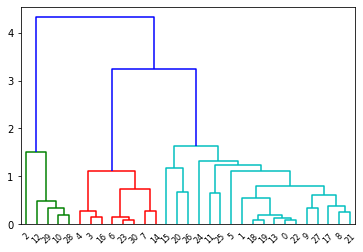

In [347]:
Z = hierarchy.linkage(vals_pca, method = "average", metric = 'euclidean')
plt.figure()
dn = hierarchy.dendrogram(Z)

Decent hierarchy graph, looks like 1.5 would be a good threshold

In [350]:
threshold = 1.5
C = hierarchy.fcluster(Z, threshold, criterion="distance")
labels = (C).tolist()
labels = ['cluster_'+str(s) for s in labels]

In [351]:
df['hierarchy_label'] = labels
print_clusters(df, 'hierarchy_label')

cluster_1 ['LONDON', 'ASIA', 'Europe', 'Canada']

cluster_2 ['NVIDIA Ireland']

cluster_3 ['SLOUGH SE12 2XY', '33 TIMBER YARD,LONDON, L1 8XY', 'XYZ 13423 / ILD', 'ABC/ICL/20891NC', 'ICNAO02312', '5 Time Square, New York, NY 10036', '4CE0460D0G', 'HGU6UH3']

cluster_4 ['TOYS', 'Ryland Group Inc.', 'Microwave']

cluster_5 ['Marks and Spencers Ltd', 'M&S Limited', '44 CHINA ROAD, KOWLOON, HONG KONG', 'HARDWOOD TABLE', 'PLASTIC BOTTLE', 'HONG KONG', 'JP Morgan & Chase Co.', 'COMPUTER PARTS', 'INTEL CORPORATION', 'INTEL CO', 'Sabre Holdings Corp', 'Safeco Corp', 'Vero Beach, Florida', 'WINE', 'Plastic container']



Proceeding with these features for the second part

# Unique entity recognition (WIP)

In [509]:
import scipy.spatial.distance as D
from sklearn import svm
from sklearn.utils import shuffle
import pickle as pk
import time
from sklearn.model_selection import GridSearchCV
import tensorflow as tf
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split


## Load labeled data

In [701]:
labeled = pd.read_csv('../data/traning_v5.csv') # test string INTEL CORPORATION

In [702]:
labeled = labeled.dropna()
labeled = labeled.drop_duplicates()
labeled = shuffle(labeled)
labeled = labeled.head(15000).reset_index(drop = True)
labeled = labeled.drop(columns = ['Unnamed: 0'])

In [703]:
labeled.head(4)

,str_1,str_2,Y
0,"MONOLITHIC POWER SYSTEMS, Incorporated","Bushey, UK",0
1,"85 Jana Road, Pine Hills, DC 08066","138 Crescent Av Avenue, Dunkirk, UT",0
2,"58961 Mandrake Street, Batley, SCT, AB56, UK","58961 Mandrake St, Batley, Scotland",1
3,WEST BANCORPORATION,"72406 Mariners Ct Court, Rockville, California",0


In [704]:
train, test = train_test_split(labeled, test_size=0.01)

In [709]:
print (train.shape, test.shape)

(14850, 14) (150, 3)


In [706]:
train = train.reset_index(drop = True)
test = test.reset_index(drop = True)

In [710]:
# preprocess - input dataset with str_1 and str_2
def concat_features(row, col): 
    concat_list = np.array([row[col+'_word_count'], row[col+'_char_count'], row[col+'_company_flag'], row[col+'_digit_ratio']])
    new_concat_list = np.append(row[col+'_vector_300'], concat_list)
    return new_concat_list

# compare first word
def first_match_boo(str_1, str_2): 
    str_1 = str_1.split()
    str_2 = str_2.split()
    if str_1[0] == str_2[0]: 
        return 1
    else: 
        return 0

# return a list of characteristics features, input data with str_1 and str2 
def get_char_features_labled(updated_df): 
    return_list = []
    for idx, row in updated_df.iterrows(): 
        append_list = []
        append_list.append(first_match_boo(row['str_1'], row['str_2']))
        append_list.append(row['str_1_word_count']-row['str_2_word_count']) # word count difference
        append_list.append(row['str_1_char_count']-row['str_2_char_count']) # character count difference
        append_list.append(len(set(row['str_1_token']).intersection(set(row['str_2_token'])))) # common word
        append_list.append(fuzz.ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz ratio
        append_list.append(fuzz.partial_ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz partical
        append_list.append(fuzz.token_set_ratio(row['str_1_clean_string'], row['str_2_clean_string'])) # fuzz token set
        append_list.append(fuzz.partial_token_sort_ratio(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(fuzz.token_sort_ratio(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(w2v.wmdistance(row['str_1_clean_string'], row['str_2_clean_string']))
        append_list.append(w2v_norm.wmdistance(row['str_1_clean_string'], row['str_2_clean_string']))
        return_list.append(append_list)
    return return_list

# return a list of distance features, input data with str_1 and str2 after normalization 
def get_dist_features_labeled(updated_df):
    v1 = np.array(updated_df['str_1_feature_concat'].tolist())
    v2 = np.array(updated_df['str_2_feature_concat'].tolist())
    return_list = []
    for i in range (v1.shape[0]): 
        append_list = []
        if v1[i].sum()==0 or v2[i].sum()==0: 
            print (updated_df.iat[i,0])
        append_list.append(D.cosine(v1[i], v2[i]))
        append_list.append(D.euclidean(v1[i], v2[i]))
        append_list.append(D.cityblock(v1[i], v2[i]))
        append_list.append(D.minkowski(v1[i], v2[i]))
        append_list.append(D.braycurtis(v1[i], v2[i]))
        append_list.append(D.canberra(v1[i], v2[i]))
        return_list.append(append_list)
    return return_list

# concat and normlize X 
def process_X(c_v, d_v): 
    return_list = []
    for i in range(len(c_v)): 
        return_list.append(c_v[i]+d_v[i])
    mat = np.array(return_list)
    mat = scale_mat(mat, 'MinMax')
    return mat

def process_df(labeled_df, col_list, build_X):
    for col in col_list: 
        labeled_df[col+'_token'] = labeled_df[col].apply(lambda x: get_tokens(x))
        labeled_df[col+'_clean_string'] = labeled_df[col+'_token'].apply(lambda x: ' '.join(x))
        labeled_df[col+'_clean_token_bi_gram'] = labeled_df[col+'_token'].apply(lambda x: get_bi_gram(x))
        labeled_df[col+'_vector_300'] = labeled_df[col+'_clean_token_bi_gram'].apply(lambda x: get_vector(x))
        labeled_df[col+'_word_count'] = labeled_df[col+'_token'].apply(lambda x: get_word_cnt(x))
        labeled_df[col+'_char_count'] = labeled_df[col+'_token'].apply(lambda x: get_char_cnt(x))
        labeled_df[col+'_company_flag'] = labeled_df[col+'_token'].apply(lambda x: get_company_flag(x))
        labeled_df[col+'_digit_ratio'] = labeled_df[col].apply(lambda x: get_digits_ratio(x))
        #labeled_df[col+'_punctuation_ratio'] = labeled_df[col].apply(lambda x: get_punc_ratio(x))
        labeled_df[col+'_feature_concat'] = labeled_df.apply(lambda row: concat_features(row, col), axis = 1)
    
    if build_X == True: 
        char_features = get_char_features_labled(labeled_df)
        #print ('Characteristics features DONE.')
        dist_features = get_dist_features_labeled(labeled_df)
        #print ('Distance features DONE. ')
        # Got features, now concat and normalize
        labeled_df['X'] = process_X(char_features, dist_features).tolist()
    return labeled_df


In [711]:

# Split X and Y 
start_time = time.time()
labeled_df = process_df(train, ['str_1', 'str_2'], build_X = True)
print ('Data processed. Time taken: ', time.time()-start_time)
X_train = np.array(labeled_df['X'].tolist())
Y_train = labeled_df['Y'].values


Data processed. Time taken:  3538.180346727371


In [712]:
X_train.shape, Y_train.shape

((14850, 17), (14850,))

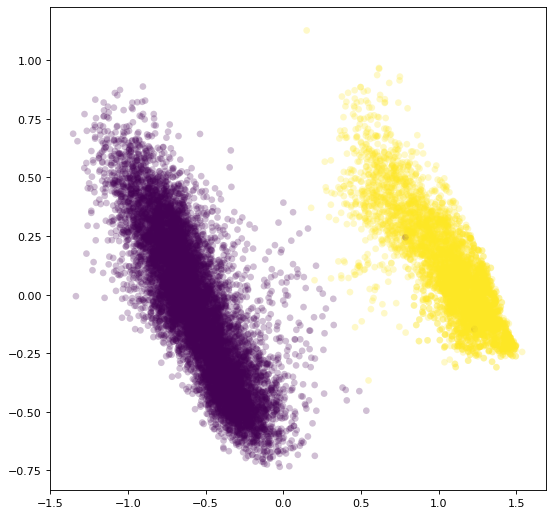

In [713]:
vals_pca_X_train = sklearn_pca.fit_transform(X_train)
plt.figure(figsize=(8, 8), dpi=80)
plt.scatter(vals_pca_X_train[:,0], vals_pca_X_train[:,1], c=Y_train, cmap='viridis', lw = 0, alpha=0.25)

In [586]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(X_train, Y_train)
reg.score(X_train, Y_train), reg.coef_

(0.8874056899606426,
 array([-0.03699152,  0.06219979, -0.16531303,  0.64495812,  0.23701884,
         1.02821345,  0.13890736, -0.109448  , -0.12802801,  0.4384727 ,
         0.34583668,  0.07114728, -0.56479084,  0.07114728,  0.56395485,
        -0.10406224]))

In [654]:
from sklearn import tree
clf_tree = tree.DecisionTreeClassifier()
clf_tree = clf_tree.fit(X_train, Y_train)

In [581]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
clf_gnb = gnb.fit(X_train, Y_train)
clf_pf = gnb.partial_fit(X_train, Y_train, np.unique(Y_train))

In [714]:
def svc_param_selection(X, y, nfolds):
    Cs = [1, 10, 100]
    gammas = [0.1, 1, 10]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='rbf'), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    return_param = grid_search.best_params_
    return return_param
param = svc_param_selection(X_train, Y_train, 4)

# Train a simple SVM 
start_time = time.time()
print ('Training...')
clf = svm.SVC(**param)
clf.fit(X_train, Y_train)
print ('Model done. Time taken: ', time.time()-start_time)

Training...
Model done. Time taken:  0.042488813400268555


In [614]:
param

{'C': 100, 'gamma': 1}

In [650]:

#tensor_model = tf.keras.Sequential()
tensor_model = tf.keras.Sequential([tf.keras.layers.Dense(17, activation=tf.nn.relu, input_shape=(17,)),\
                                    tf.keras.layers.Dense(8, activation=tf.nn.relu),\
                                    tf.keras.layers.Dense(1)])

tensor_model.compile(optimizer='adam', loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), metrics=['accuracy'])
tensor_model.fit(X_train, Y_train, batch_size=5, epochs=10)


Epoch 1/10
1194/1194 [==============================] - 1s 1ms/step - loss: 0.1118 - accuracy: 0.9571
Epoch 2/10
1194/1194 [==============================] - 1s 1ms/step - loss: 0.0057 - accuracy: 0.9990: 0s - loss: 0.006
Epoch 3/10
1194/1194 [==============================] - 1s 1ms/step - loss: 0.0050 - accuracy: 0.9990
Epoch 4/10
1194/1194 [==============================] - 1s 1ms/step - loss: 0.0044 - accuracy: 0.9990
Epoch 5/10
1194/1194 [==============================] - 1s 1ms/step - loss: 0.0046 - accuracy: 0.9987
Epoch 6/10
1194/1194 [==============================] - 2s 1ms/step - loss: 0.0044 - accuracy: 0.9992
Epoch 7/10
1194/1194 [==============================] - 2s 1ms/step - loss: 0.0043 - accuracy: 0.9988
Epoch 8/10
1194/1194 [==============================] - 2s 1ms/step - loss: 0.0037 - accuracy: 0.9992
Epoch 9/10
1194/1194 [==============================] - 2s 2ms/step - loss: 0.0043 - accuracy: 0.9992
Epoch 10/10
1194/1194 [==============================] - 2s 1ms/

In [577]:
tensor_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 10)                170       
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 11        
Total params: 453
Trainable params: 453
Non-trainable params: 0
_________________________________________________________________


In [149]:
#pk.dump( clf, open( "../data/svm_1.pkl", "wb" ) )

Now test the classifier with new strings 

In [630]:
# positive testing 
test_1 = test[test['Y'] == 1]

In [720]:
data_inventory = test_1['str_1'].tolist()+['INTEL CORP.', 'BIU297H', '5 Time Sqaure, New York, NY', 'Marks and Spencer Ltd.']
TESTING_STRING = test_1['str_2'].tolist()+['GYU8/78', '5 Time Square, NY, NY 10036', 'CITIZENS, INC.', \
                                           'Wichita, Kansas', 'M&S Limited', 'INTEL Corperation']#[-3:]

In [721]:
print (data_inventory)
print(TESTING_STRING)

['Downpatrick, Great Britain', 'Soham, GB', 'Kingston, ENG, GB', 'Jonesboro, Maine', '94423 Armistice Plaza, Wolcott, CA 97604', '256 Elka Dr, Tishomingo, Texas 28402', 'Hayling Island, GB', '4857 Vera Way, Hertford, ENG, NG34, UK', '67 Farragut Dr, Esher, ENG, LE15', '16079 Toban Way, Ullapool, Scotland', 'Delphos, OH, USA', 'Highlands, North Carolina', 'Olivette, MO', 'INTEL CORP.', 'BIU297H', '5 Time Sqaure, New York, NY', 'Marks and Spencer Ltd.']
['Downpatrick, NIR, GB', 'Soham, ENG, UK', 'Kingston, Great Britain', 'Jonesboro, Maine, United States', '94423 Armistice Plaza, Wolcott, CA 97604, USA', '256 Elka Dr, Tishomingo, Texas', 'Hayling Island, United Kingdom', '4857 Vera Way, Hertford, ENG, NG34', '67 Farragut Dr, Esher, ENG', '16079 Toban Way, Ullapool, SCT', 'Delphos, Ohio, US', 'Highlands, NC, USA', 'Olivette, Missouri', 'GYU8/78', '5 Time Square, NY, NY 10036', 'CITIZENS, INC.', 'Wichita, Kansas', 'M&S Limited', 'INTEL Corperation']


In [722]:
testing_df = pd.DataFrame()
testing_df['str_1'] = data_inventory
testing_df = process_df(testing_df, col_list = ['str_1'], build_X = False)

def print_res(data_inv_df, testing_list, model): 
    for testing_str in testing_list: 
        data_inv_df['str_2'] = testing_str
        new_df = process_df(data_inv_df, ['str_2'], build_X = True)
        X_test = np.array(new_df['X'].tolist())
        P = model.predict(X_test)

        new_df['predicted'] = P.tolist()
        
        entity_list = new_df[new_df.predicted==1]['str_1'].tolist()
        if len(entity_list)>0: 
            print (testing_str, ':', entity_list)
        if P.sum() == 0: 
            print (testing_str, ':', 'NEW ENTITY!')

In [723]:
print_res(testing_df, TESTING_STRING, clf) #good: clf, clf_tree, clf_tree

Downpatrick, NIR, GB : ['Downpatrick, Great Britain']
Soham, ENG, UK : ['Soham, GB']
Kingston, Great Britain : ['Kingston, ENG, GB']
Jonesboro, Maine, United States : ['Jonesboro, Maine']
94423 Armistice Plaza, Wolcott, CA 97604, USA : ['94423 Armistice Plaza, Wolcott, CA 97604']
256 Elka Dr, Tishomingo, Texas : ['256 Elka Dr, Tishomingo, Texas 28402']
Hayling Island, United Kingdom : ['Hayling Island, GB']
4857 Vera Way, Hertford, ENG, NG34 : ['4857 Vera Way, Hertford, ENG, NG34, UK']
67 Farragut Dr, Esher, ENG : ['67 Farragut Dr, Esher, ENG, LE15']
16079 Toban Way, Ullapool, SCT : ['16079 Toban Way, Ullapool, Scotland']
Delphos, Ohio, US : ['Delphos, OH, USA']
Highlands, NC, USA : ['Highlands, North Carolina']
Olivette, Missouri : ['Olivette, MO']
GYU8/78 : NEW ENTITY!
5 Time Square, NY, NY 10036 : ['5 Time Sqaure, New York, NY']
CITIZENS, INC. : NEW ENTITY!
Wichita, Kansas : NEW ENTITY!
M&S Limited : NEW ENTITY!
INTEL Corperation : ['INTEL CORP.']


In [638]:
# negative testing 
test_2 = test[test['Y'] == 0]
data_inventory = test_2['str_1'].tolist()
TESTING_STRING = test_2['str_2'].tolist()
testing_df = pd.DataFrame()
testing_df['str_1'] = data_inventory 
testing_df = process_df(testing_df, col_list = ['str_1'], build_X = False)

In [639]:
print(data_inventory)

['MOLECULIN BIOTECH, INC.', 'CITIZENS, INC.', 'Luton, ENG, GB', 'INOTEK PHARMACEUTICALS Corp.', 'San Ardo, CA', '0566 Orin Lane, Castleford, ENG', 'Droitwich Spa, ENG, GB', 'Jeffers, Minnesota', 'SODASTREAM INTERNATIONAL LTD.', '6689 Harper Trail, Stroud, ENG, WC1B, UK', 'Wilcox, Nebraska, US', 'Franconia, Pennsylvania, US', '826 Eliot Ctr, Plain, IN 65194', '97208 Fordem Junction, Spiceland, New York', 'La Center, KY', '038 Hoard Drive, Shipley, ENG', '6 Garrison Plz, Lumberton, Florida 17429, USA']


In [640]:
print_res(testing_df, TESTING_STRING, clf)

LIBERTY MEDIA Corp. : ['INOTEK PHARMACEUTICALS Corp.']
LCNB CORPORATION : []
Sawtry, United Kingdom : []
A V HOMES, Incorporated : []
1 Weeping Hl Hill, Mount Olivet, LA 25647 : ['826 Eliot Ctr, Plain, IN 65194']
86464 Lyons Pass, Spotswood, HI : ['0566 Orin Lane, Castleford, ENG', '6689 Harper Trail, Stroud, ENG, WC1B, UK', '826 Eliot Ctr, Plain, IN 65194', '038 Hoard Drive, Shipley, ENG']
Dixon, Illinois, US : ['Franconia, Pennsylvania, US']
Bainbridge Island, Washington, US : ['Wilcox, Nebraska, US', 'Franconia, Pennsylvania, US']
Grand Coteau, LA : ['La Center, KY']
013 Prairie Dr Drive, Roslyn, Louisiana 85348, USA : ['038 Hoard Drive, Shipley, ENG', '6 Garrison Plz, Lumberton, Florida 17429, USA']
Glen Head, New York, US : []
Wichita, Kansas : []
SIBANYE GOLD Ltd. : ['SODASTREAM INTERNATIONAL LTD.']
INVESTORS BANCORP, Incorporated : ['INOTEK PHARMACEUTICALS Corp.']
Simsbury, CT : []
69007 Vidon Jct, Bridge of Weir, England, BS37 : ['0566 Orin Lane, Castleford, ENG', '6689 Harper 

In [259]:
for testing_str in TESTING_STR_TRUE: 
    new_df = pd.DataFrame({'str_1': data_inventory.tolist()})
    new_df['str_2'] = testing_str
    new_df = process_df(new_df)
    X_test = np.array(new_df['X'].tolist())
    P = clf_pf.predict(X_test)
    new_df['clf'] = P.tolist()
    entity_list = new_df[new_df.clf==1]['str_1'].tolist()
    print (testing_str, ':', entity_list)

INTEL CO : ['Pepsi Co.', 'INTEL CORPORATION']
IBM Corporation : ['INTEL CORPORATION']
Shanghai, China : ['Pepsi Co.', 'United States of America', 'VERO BEACH, FLORIDA', 'Los Angeles, CA', 'RYLAND GROUP INC.', 'INTEL CORPORATION', '44 CHINA ROAD, KOWLOON, HONG KONG']
Allentown, PA, USA : ['Allentown, Pennsylvania']
Seoul, SK : ['Pepsi Co.', 'Los Angeles, CA', 'RYLAND GROUP INC.', 'Ernst & Young LLP']
GYU671A3 : ['5 Time Sqaure, New York, NY 10036', '44 CHINA ROAD, KOWLOON, HONG KONG', 'ICNAO02312']
M&S Limited : ['Marks and Spencers Ltd', 'Los Angeles, CA', 'Ernst & Young LLP']
Pepsico : ['Pepsi Co.']
5 Time Sqaure, NY, NY : ['5 Time Sqaure, New York, NY 10036']


In [260]:
for testing_str in TESTING_STR_FALSE: 
    new_df = pd.DataFrame({'str_1': data_inventory.tolist()})
    new_df['str_2'] = testing_str
    new_df = process_df(new_df)
    X_test = np.array(new_df['X'].tolist())
    P = clf_pf.predict(X_test)
    new_df['clf'] = P.tolist()
    entity_list = new_df[new_df.clf==1]['str_1'].tolist()
    print (testing_str, ':', entity_list)

Apple Inc. : ['Pepsi Co.', 'Marks and Spencers Ltd', 'Los Angeles, CA', 'RYLAND GROUP INC.', 'INTEL CORPORATION']
Sunrise Corporation : ['INTEL CORPORATION']
Palm Beach, FL : ['VERO BEACH, FLORIDA', 'Los Angeles, CA']
Toronto, Canada : ['LONDON', 'VERO BEACH, FLORIDA', 'Marks and Spencers Ltd', 'Los Angeles, CA', 'INTEL CORPORATION']
Austin, TX : ['INTEL CORPORATION']
PwC LLP : ['Ernst & Young LLP']


In [261]:
X_train.shape

(21889, 17)

### Archive

In [687]:
# Warp - Preprocess and get vector features (303,), return dictionary 
def get_feature_vector_303(string_input): 
    new_string_dict = { i : '' for i in df.columns}
    token = get_tokens(string_input)
    word_vec_google = get_vector(token)
    word_cnt = get_word_cnt(token)
    char_cnt = get_char_cnt(token)
    com_flag = get_company_flag(token)
    extra_features = np.array([word_cnt, char_cnt, com_flag])
    v = np.append(word_vec_google, extra_features)
    
    new_string_dict['text'] = string_input
    new_string_dict['clean_token'] = token
    new_string_dict['clean_string'] = ' '.join(token)
    new_string_dict['vecter_300'] = word_vec_google
    new_string_dict['word_count'] = word_cnt
    new_string_dict['char_count'] = char_cnt
    new_string_dict['company_str'] = com_flag
    new_string_dict['new_feature_concat'] = v
    #v = scale_mat(v.reshape(-1,1),'MinMax')
    return new_string_dict

In [1114]:
def scaler_for_df(df, scale_type): 
    df_array = np.array(df['new_feature_concat'].tolist())
    df_array = scale_mat(df_array,scale_type)
    return df_array

In [749]:
df.head(2)

,text,clean_token,vecter_300,word_count,char_count,company_str,new_feature_concat,2D,clean_string
0,Marks and Spencers Ltd,"[marks, and, spencers, ltd]","[-0.081870556, -0.028320312, -0.05102539, 0.10...",4,19,1,"[-0.08187055587768555, -0.0283203125, -0.05102...","[-0.3339800956502091, -0.35841218689219334]",marks and spencers ltd
1,M&S Limited,"[m, &, s, limited]","[-0.15039062, 0.09075928, -0.11743164, 0.13623...",4,10,1,"[-0.150390625, 0.09075927734375, -0.1174316406...","[-0.5162413962301977, -0.026243635885206534]",m & s limited


In [1054]:
test_string = 'London United Kingdom'
test_dict = get_feature_vector_303(test_string)

In [1055]:
df = df.append(test_dict, ignore_index=True)

In [1060]:
# return a list of characteristics features
def get_char_features(updated_df, new_string_dict): 
    return_list = []
    for idx, row in updated_df.iterrows(): 
        append_list = []
        append_list.append(row['word_count']-new_string_dict['word_count']) # word count difference
        append_list.append(row['char_count']-new_string_dict['char_count']) # character count difference
        append_list.append(len(set(row['clean_token']).intersection(set(new_string_dict['clean_token'])))) # common word
        append_list.append(fuzz.ratio(row['clean_string'], new_string_dict['clean_string'])) # fuzz ratio
        append_list.append(fuzz.partial_ratio(row['clean_string'], new_string_dict['clean_string'])) # fuzz partical
        append_list.append(fuzz.token_set_ratio(row['clean_string'], new_string_dict['clean_string'])) # fuzz token set
        return_list.append(append_list)
    return return_list

In [1057]:
vector_matrix = np.array(df['new_feature_concat'].tolist())
vector_matrix = scale_mat(vector_matrix, 'MinMax')
vals_pca = sklearn_pca.fit_transform(vector_matrix)
df['2D'] = vals_pca.tolist()

In [1058]:
# return s list of distance features
# input df after appeding the new string because need to do PCA 
def get_dist_features(updated_df): 
    new_vec = updated_df.tail(1)['2D'].to_numpy()[0]
    old_vec = updated_df['2D']
    return_list = []
    for v in old_vec: 
        #print (updated_df.iat[i,0], i)
        v = np.array(v)
        append_list = []
        append_list.append(D.cosine(v, new_vec))
        append_list.append(D.euclidean(v, new_vec))
        append_list.append(D.cityblock(v, new_vec))
        append_list.append(D.minkowski(v, new_vec))
        return_list.append(append_list)
    return return_list

In [1061]:
char_v = get_char_features(df, test_dict)
dist_v = get_dist_features(df)

In [1062]:
# concat and normlize X 
def process_X(c_v, d_v): 
    return_list = []
    for i in range(len(c_v)): 
        return_list.append(c_v[i]+d_v[i])
    mat = np.array(return_list)
    mat = scale_mat(mat, 'MinMax')
    return mat

In [1069]:
# update training df
train_df = pd.DataFrame(columns = ['str_1', 'str_2', 'X', 'Y'])
train_df['str_1'] = df['text']
train_df['str_2'] = test_string

In [1070]:
X = process_X(char_v, dist_v)

In [1071]:
df.shape, train_df.shape

((34, 9), (34, 4))

In [1072]:
train_df['X'] = X.tolist()

In [1075]:
# label data
train_df['Y'] = 0
train_df.iat[10,3] = 1
train_df.iat[33,3] = 1

In [1077]:
train_df_2 = train_df

In [1052]:
train_df_1 = train_df

In [1078]:
all_train = pd.concat([train_df_1, train_df_2])

In [1087]:
X = np.array(all_train['X'].tolist())

In [1088]:
X.shape

(67, 10)

SVC()

In [1035]:
train_df.shape

(33, 5)

In [1115]:
# try out the classifier 
try_string = 'vb, florida'
try_dict = get_feature_vector_303(try_string)
try_df = df.append(try_dict, ignore_index=True)

#vector_matrix = np.array(try_df['new_feature_concat'].tolist())
#vector_matrix = scale_mat(vector_matrix, 'MinMax')
vector_matrix = scaler_for_df(try_df, 'MinMax')
vals_pca = sklearn_pca.fit_transform(vector_matrix)

try_df['2D'] = vals_pca.tolist()
try_char_v = get_char_features(try_df, test_dict)
try_dist_v = get_dist_features(try_df)
try_X = process_X(try_char_v, try_dist_v)

print (try_X.shape)

new_train = pd.DataFrame()
new_train['str_1'] = try_df['text']
new_train['str_2'] = try_string


(35, 10)


In [1104]:
P = clf.predict(try_X)

In [1105]:
new_train['clf'] = P.tolist()

In [838]:
'''
for idx, row in my_df.iterrows(): 
    my_dict = row.to_dict()
    character_list = []
    character_list.append(my_dict['word_cnt']-test_w_cnt) 
    character_list.append(my_dict['char_cnt']-test_c_cnt) 
    character_list.append(len(set(my_dict['clean_token']).intersection(set(test_token)))) # number of common word
    character_list.append(fuzz.ratio(my_dict['clean_string'], test_clean_string)) # fuzz ratio
    character_list.append(fuzz.partial_ratio(my_dict['clean_string'], test_clean_string)) # fuzz partical
    character_list.append(fuzz.token_set_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.token_sort_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.partial_token_set_ratio(my_dict['clean_string'], test_clean_string))
    character_list.append(fuzz.partial_token_sort_ratio(my_dict['clean_string'], test_clean_string))
    print (character_list)
'''

"\nfor idx, row in my_df.iterrows(): \n    my_dict = row.to_dict()\n    character_list = []\n    character_list.append(my_dict['word_cnt']-test_w_cnt) \n    character_list.append(my_dict['char_cnt']-test_c_cnt) \n    character_list.append(len(set(my_dict['clean_token']).intersection(set(test_token)))) # number of common word\n    character_list.append(fuzz.ratio(my_dict['clean_string'], test_clean_string)) # fuzz ratio\n    character_list.append(fuzz.partial_ratio(my_dict['clean_string'], test_clean_string)) # fuzz partical\n    character_list.append(fuzz.token_set_ratio(my_dict['clean_string'], test_clean_string))\n    character_list.append(fuzz.token_sort_ratio(my_dict['clean_string'], test_clean_string))\n    character_list.append(fuzz.partial_token_set_ratio(my_dict['clean_string'], test_clean_string))\n    character_list.append(fuzz.partial_token_sort_ratio(my_dict['clean_string'], test_clean_string))\n    print (character_list)\n"

In [515]:
# return a matrix of all kinds of distances 
def get_all_dist(v1, v2): 
    dist_list = []
    dist_list.append(D.cosine(v1, v2))
    dist_list.append(D.euclidean((v1, v2)))
    return np.array(dist_list)

In [403]:
get_cosine_dist(init_vector, test_vector)

(303, 1)


0.018331223903671368

In [333]:

a = df.iloc[0,3]
b = df.iloc[1,3]
cos_sim = dot(a, b)/(norm(a)*norm(b))

In [334]:
cos_sim

0.8627565141838561

In [ ]:
df.iloc[2,0]

In [ ]:
from scipy import spatial

result = 1-spatial.distance.cosine(a, b)

In [ ]:
print (w2v.distance('corporation', 'co'))
print (w2v.wmdistance('corporation', 'co'))
print (w2v_norm.distance('corporation', 'co'))
print (w2v_norm.wmdistance('corporation', 'co'))
'''
def compute_similarity(s1, s2):
    return 1.0 - (0.01 * max(fuzz.ratio(s1, s2),fuzz.token_sort_ratio(s1, s2),fuzz.token_set_ratio(s1, s2)))
compute_similarity('INTELCORPORATION', 'INTELCO')
'''

In [ ]:
# add distance 
def get_distance(v1, v2): 
    return w2v.distance(a, b)

# add Word Mover's Distance
def get_WMD(v1, v2): 
    return w2v_norm.wmdistance(a, b)

def get_word_delta(tokens_1, tokens_2): 
    return 

In [ ]:
def dist_metric(a, b):
    sim = np.isnan(dot(a, b)/(norm(a)*norm(b)))
    if sim == False:
        return dot(a, b)/(norm(a)*norm(b))